In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymc import Model, Normal, sample, HalfNormal
import arviz as az

import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
import warnings

import riskfolio as rp
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
start = '2014-12-31'
end = '2022-12-31'
ext_factors = pd.read_parquet('factors.parquet')
stock_prices = pd.read_parquet('stock_prices.parquet')
stock_rets = stock_prices.pct_change()
stock_return_daily = stock_rets.copy()
stock_rets = stock_rets.loc[start:end, :]
ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)

ext_factors[[f'{factor}_lag' for factor in ext_factors.columns]] = ext_factors.shift(1)
stock_rets[[f'{symbol}_lag' for symbol in stock_rets.columns]] = stock_rets.shift(1)

ext_factors = ext_factors.dropna()
stock_rets = stock_rets.dropna()


C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_348\1610211889.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_rets = stock_prices.pct_change()
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_348\1610211889.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_348\1610211889.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)


In [3]:
# train/test split
start_train_at = '2014-12-31'
end_train_at = '2021-12-31'
start_test_at = '2022-01-31'
X_train = pd.concat([stock_rets.loc[start_train_at:end_train_at, :], ext_factors.loc[start_train_at:end_train_at, :]], axis=1)
X_test = pd.concat([stock_rets.loc[start_test_at:, :], ext_factors.loc[start_test_at:, :]], axis=1)

In [35]:
model_dict = {}
# universe = ['MINT.BK', 'BANPU.BK', 'TOP.BK', 
#            'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
#            'WHA.BK', 'SCC.BK','CPN.BK', 
#            'CENTEL.BK', 'PTT.BK', 'BCP.BK']
universe = ['MINT.BK']
# symbols = ['SET_index']
def train(universe, with_esg=True):
    for symbol in universe:
        with Model() as model:
            if with_esg:
                beta0 = Normal('beta0', 0, 10)
                beta1 = Normal('beta1', 0, 10)
                beta2 = Normal('beta2', 0, 10)
                beta3 = Normal('beta3', 0, 10)
                beta4 = Normal('beta4', 0, 10)
                stdev = HalfNormal('stdev', 10)
                X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
                R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
                R_l2 = pm.MutableData('lagged_R_l2',X_train.loc[:, 'E_lag'].values)
                R_l3 = pm.MutableData('lagged_R_l3',X_train.loc[:, 'S_lag'].values)
                R_l4 = pm.MutableData('lagged_R_l4',X_train.loc[:, 'G_lag'].values)
                X = X_train.loc[:, symbol].values
                mu = X_l1 * beta0 + R_l1 * beta1 + R_l2 * beta2 + R_l3 * beta3 + R_l4 * beta4
                obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
                ar_trace = sample(20000, chains=1)
                model_dict[symbol] = ar_trace
            else:
                beta0 = Normal('beta0', 0, 10)
                beta1 = Normal('beta1', 0, 10)
                stdev = HalfNormal('stdev', 10)
                X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
                R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
                X = X_train.loc[:, symbol].values
                mu = X_l1 * beta0 + R_l1 * beta1
                obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
                ar_trace = sample(20000, chains=1)
                model_dict[symbol] = ar_trace
    return model_dict


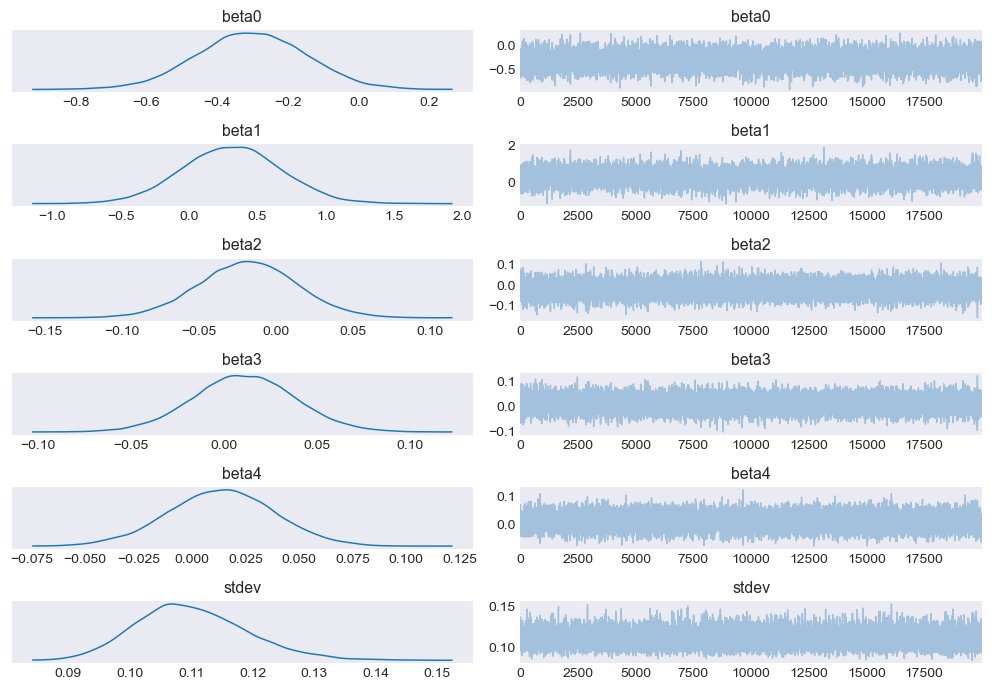

In [40]:
az.plot_trace(model_dict['MINT.BK'], figsize=(10, 7))
plt.tight_layout()

In [5]:
import numpy as np
def predict(X, symbol, model, with_esg=True):
    draw = model.posterior['draw'].shape[0]
    
    beta0_sample = model.posterior['beta0']
    beta1_sample = model.posterior['beta1']
    if with_esg:
        beta2_sample = model.posterior['beta2']
        beta3_sample = model.posterior['beta3']
        beta4_sample = model.posterior['beta4']
        next_period_return = (X[f'{symbol}_lag'] * beta0_sample +
                              X['mkt_lag'] * beta1_sample + 
                              X['E_lag'] * beta2_sample + 
                              X['S_lag'] * beta3_sample + 
                              X['G_lag'] * beta4_sample)
    else:
        next_period_return = (X[f'{symbol}_lag'] * beta0_sample +
                              X['mkt_lag'] * beta1_sample)

    next_period_return = np.array(next_period_return).reshape(draw, )
    return next_period_return 

In [38]:
model_dict = train(universe, with_esg=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
weights_dict = {}
perf_dict = {}
for idx in X_test.index:
    print(idx)
    portfolio = stock_prices.loc['2022-01-01':idx, universe]
    market_prices = stock_prices.loc['2015-01-01':idx, 'SET_index']
    mcaps = {}
    for t in universe:
        stock = yf.Ticker(t)
        mcaps[t] = stock.info["marketCap"]
    S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

    views = {}
    view_uncertainty = {}
    for symbol in universe:
        pred = predict(X_test.loc[idx, :], symbol, model_dict[symbol], with_esg=False)
        views[symbol] = pred.mean()
        view_uncertainty[symbol] = pred.var()

    omega = np.diag(list(view_uncertainty.values()))

    bl = BlackLittermanModel(S, pi="equal",
                             absolute_views=views, omega=omega)

    ret_bl = bl.bl_returns()
    S_bl = bl.bl_cov()

    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe(risk_free_rate=0.0227/12)
    weights = ef.clean_weights()
    weights_dict[idx] = weights
    perf_dict[idx] = ef.portfolio_performance(risk_free_rate=0.0227/12, verbose=True)


2022-01-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 2.0%
Annual volatility: 18.5%
Sharpe Ratio: 0.10
2022-02-28 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 0.7%
Annual volatility: 14.5%
Sharpe Ratio: 0.03
2022-03-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 2.4%
Annual volatility: 30.5%
Sharpe Ratio: 0.07
2022-04-30 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 0.8%
Annual volatility: 19.0%
Sharpe Ratio: 0.03
2022-05-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 1.4%
Annual volatility: 27.2%
Sharpe Ratio: 0.04
2022-06-30 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 0.8%
Annual volatility: 19.9%
Sharpe Ratio: 0.03
2022-07-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 1.3%
Annual volatility: 19.6%
Sharpe Ratio: 0.05
2022-08-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 2.4%
Annual volatility: 32.0%
Sharpe Ratio: 0.07
2022-09-30 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 2.9%
Annual volatility: 29.6%
Sharpe Ratio: 0.09
2022-10-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 3.1%
Annual volatility: 21.1%
Sharpe Ratio: 0.14
2022-11-30 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 0.5%
Annual volatility: 19.8%
Sharpe Ratio: 0.01
2022-12-31 00:00:00
Expected annual return: 1.6%
Annual volatility: 28.2%
Sharpe Ratio: 0.05


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [73]:
X_test.loc[:pd.to_datetime('2022-02-28')].index[-1]

Timestamp('2022-02-28 00:00:00')

In [88]:
stock_rets.index.to_list()[83]

Timestamp('2022-01-31 00:00:00')

In [9]:
from dateutil.relativedelta import relativedelta
import pandas as pd

# Example datetime
my_datetime = pd.to_datetime('2023-01-31')

# Add one month
my_datetime_plus_one_month = my_datetime + relativedelta(months=1)

print(my_datetime_plus_one_month.date())

2023-02-28


In [10]:
weights_df = pd.DataFrame(weights_dict).T

In [11]:
perf_df = pd.DataFrame(perf_dict, index=['Annualized return', 'Annualized volatility', 'Sharpe ratio']).T

In [12]:
perf_df['Sharpe ratio'].mean()

0.06014962601055857

In [13]:
# weights_df.to_csv('weights_without_esg.csv')

In [14]:
# perf_df.to_csv('perf_without_esg.csv')

In [15]:
weights_df

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
2022-01-31,0.01047,0.26789,0.00000,0.28960,0.05524,0.00000,0.10725,0.00000,0.00000,0.00000,0.04420,0.22535
2022-02-28,0.00000,0.21563,0.12863,0.00000,0.00000,0.00000,0.25199,0.00000,0.34010,0.06366,0.00000,0.00000
2022-03-31,0.03292,0.05693,0.00000,0.55833,0.09199,0.00000,0.24381,0.00000,0.00000,0.00000,0.01601,0.00000
2022-04-30,0.00000,0.14231,0.00000,0.13994,0.00000,0.00000,0.33935,0.00000,0.00000,0.00000,0.00000,0.37841
2022-05-31,0.00000,0.75631,0.09999,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14370,0.00000,0.00000
2022-06-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.76978,0.00000,0.00000,0.00000,0.00000,0.23022
2022-07-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.08230,0.00000,0.38041,0.00000,0.53729,0.00000,0.00000
2022-08-31,0.06007,0.13447,0.00000,0.46699,0.00000,0.00000,0.11198,0.00000,0.00000,0.00000,0.00000,0.22648
2022-09-30,0.20598,0.27098,0.00000,0.40234,0.07594,0.00000,0.00000,0.00000,0.00000,0.00000,0.04475,0.00000
2022-10-31,0.53906,0.00000,0.00000,0.00459,0.00000,0.00000,0.00000,0.00000,0.07303,0.13204,0.00000,0.25129


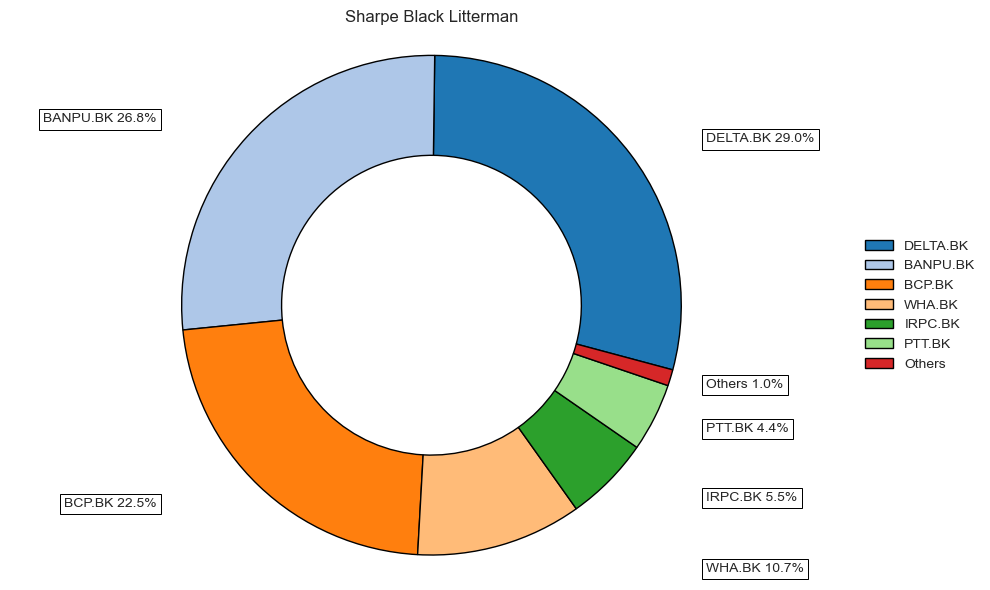

In [16]:
ax = rp.plot_pie(w=weights_df.iloc[0, :].to_frame(), title='Sharpe Black Litterman', others=0.05, nrow=25,
                 cmap="tab20", height=6, width=10, ax=None)


In [17]:
weights_df

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
2022-01-31,0.01047,0.26789,0.00000,0.28960,0.05524,0.00000,0.10725,0.00000,0.00000,0.00000,0.04420,0.22535
2022-02-28,0.00000,0.21563,0.12863,0.00000,0.00000,0.00000,0.25199,0.00000,0.34010,0.06366,0.00000,0.00000
2022-03-31,0.03292,0.05693,0.00000,0.55833,0.09199,0.00000,0.24381,0.00000,0.00000,0.00000,0.01601,0.00000
2022-04-30,0.00000,0.14231,0.00000,0.13994,0.00000,0.00000,0.33935,0.00000,0.00000,0.00000,0.00000,0.37841
2022-05-31,0.00000,0.75631,0.09999,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14370,0.00000,0.00000
2022-06-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.76978,0.00000,0.00000,0.00000,0.00000,0.23022
2022-07-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.08230,0.00000,0.38041,0.00000,0.53729,0.00000,0.00000
2022-08-31,0.06007,0.13447,0.00000,0.46699,0.00000,0.00000,0.11198,0.00000,0.00000,0.00000,0.00000,0.22648
2022-09-30,0.20598,0.27098,0.00000,0.40234,0.07594,0.00000,0.00000,0.00000,0.00000,0.00000,0.04475,0.00000
2022-10-31,0.53906,0.00000,0.00000,0.00459,0.00000,0.00000,0.00000,0.00000,0.07303,0.13204,0.00000,0.25129


In [18]:
return_df_monthly = pd.DataFrame()
for i in weights_df.columns:
    print(i)
    return_df_monthly[i] = stock_rets[i]*weights_df[i].shift(1)
    # perf_return = stock_return_daily[]
return_df_monthly

MINT.BK
BANPU.BK
TOP.BK
DELTA.BK
IRPC.BK
PTTGC.BK
WHA.BK
SCC.BK
CPN.BK
CENTEL.BK
PTT.BK
BCP.BK


,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.000000,0.000000,0.0,0.000000,0.000000,0.006045,0.00000,-0.009263,0.000000,0.009594,0.000000e+00,0.000000
2022-09-30,-0.011464,-0.016696,-0.0,0.115856,-0.000000,-0.000000,0.00064,-0.000000,-0.000000,0.000000,-0.000000e+00,-0.036944
2022-10-31,0.013602,0.004406,0.0,-0.045525,0.001467,0.000000,0.00000,-0.000000,0.000000,0.000000,2.632362e-03,0.000000
2022-11-30,0.047704,0.000000,0.0,0.000728,-0.000000,0.000000,-0.00000,0.000000,0.003983,-0.003252,-0.000000e+00,0.012359


In [19]:
return_df_monthly = return_df_monthly.dropna()
return_df_monthly['SUM'] = return_df_monthly.sum(axis = 1)
return_df_monthly

C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_348\847114757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df_monthly['SUM'] = return_df_monthly.sum(axis = 1)


,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK,SUM
2022-02-28,0.000086,-0.004827,0.000000,0.048975,0.002035,-0.000000,-0.000627,0.000000,0.000000,-0.000000,5.666698e-04,0.026392,0.072601
2022-03-31,0.000000,0.001978,-0.000046,-0.000000,-0.000000,-0.000000,-0.001482,-0.000000,0.026982,0.010610,-0.000000e+00,-0.000000,0.038042
2022-04-30,0.001474,0.008168,0.000000,-0.035975,-0.002067,-0.000000,-0.001443,-0.000000,0.000000,0.000000,-4.158424e-04,0.000000,-0.030258
2022-05-31,0.000000,0.001157,0.000000,-0.006554,-0.000000,-0.000000,-0.008705,0.000000,0.000000,-0.000000,0.000000e+00,-0.005648,-0.019749
2022-06-30,-0.000000,0.012199,-0.011206,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.006843,-0.000000e+00,-0.000000,0.007836
2022-07-31,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.015094,-0.000000,0.000000,-0.000000,0.000000e+00,-0.012892,-0.027986
2022-08-31,-0.000000,0.000000,0.000000,0.000000,0.000000,0.006045,0.000000,-0.009263,0.000000,0.009594,0.000000e+00,0.000000,0.006376
2022-09-30,-0.011464,-0.016696,-0.000000,0.115856,-0.000000,-0.000000,0.000640,-0.000000,-0.000000,0.000000,-0.000000e+00,-0.036944,0.051393
2022-10-31,0.013602,0.004406,0.000000,-0.045525,0.001467,0.000000,0.000000,-0.000000,0.000000,0.000000,2.632362e-03,0.000000,-0.023417
2022-11-30,0.047704,0.000000,0.000000,0.000728,-0.000000,0.000000,-0.000000,0.000000,0.003983,-0.003252,-0.000000e+00,0.012359,0.061522


In [32]:
return_df_monthly['SUM'].mean()

0.013420004767521199

In [21]:
weights_df_daily = stock_return_daily.copy()
weights_df_daily

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,TTB.BK,TTCL.BK,TTW.BK,TU.BK,TVO.BK,TWPC.BK,UAC.BK,VGI.BK,WHA.BK,SET_index
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-0.005814,0.048128,0.005555,-0.027397,-0.055555,-0.010239,-0.014085,-0.040540,-0.028846,-0.053572,...,-0.010309,-0.039682,0.000000,-0.032143,0.016216,-0.009709,-0.050314,-0.047368,-0.060000,NaN
2014-01-06,0.035088,0.025510,-0.005525,0.000000,0.058823,-0.017241,-0.004762,-0.014085,-0.009901,-0.047170,...,0.026041,0.000000,0.005181,-0.040591,-0.010638,0.024510,-0.006623,-0.055249,-0.038298,NaN
2014-01-07,0.050847,0.044777,0.000000,-0.007042,0.000000,0.063158,0.038278,-0.035714,0.000000,0.029703,...,0.010153,0.049587,-0.025773,0.003846,0.048387,0.000000,0.000000,0.058480,0.017699,NaN
2014-01-08,-0.021505,-0.019048,0.000000,0.000000,-0.023809,-0.042904,-0.004608,-0.029630,0.000000,0.019231,...,0.015076,0.007874,-0.015873,-0.007663,-0.015385,0.004785,0.026667,0.027624,0.004348,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.005051,0.004545,0.006390,-0.018182,0.019048,-0.004132,0.009091,-0.014599,-0.008368,0.000000,...,-0.006250,-0.010753,-0.005495,0.006993,0.000000,0.000000,-0.005435,-0.010638,0.019417,0.0
2023-12-25,-0.015075,0.000000,-0.015873,0.018519,-0.009346,0.004149,0.018018,0.014815,0.000000,-0.014815,...,0.006289,0.000000,0.005525,0.013889,0.000000,0.010582,0.021858,0.021505,-0.019048,0.0
2023-12-26,0.005102,-0.009050,0.000000,-0.009091,0.018868,-0.008264,0.008850,0.043796,0.000000,0.007519,...,0.006250,0.000000,0.005494,0.013699,0.009479,0.036649,-0.005348,-0.010526,0.019417,0.0


In [22]:
weights_df_daily = weights_df_daily.loc[weights_df.index[0]:weights_df.index[-1]+relativedelta(months=1),weights_df.columns.to_list()]

weights_df_daily

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
Date,,,,,,,,,,,,
2022-01-31,0.008264,0.037383,0.000000,0.023599,0.005291,-0.004405,0.011834,-0.007732,0.014019,0.007194,0.006452,0.000000
2022-02-01,0.008197,-0.009009,0.004762,0.060519,0.005263,0.000000,0.005848,0.000000,-0.004608,0.007143,-0.006410,0.000000
2022-02-02,-0.008130,-0.009091,-0.014218,0.059782,-0.005236,0.000000,-0.005814,-0.002597,0.000000,-0.007092,0.000000,0.000000
2022-02-03,-0.008197,-0.009174,-0.004808,0.010257,0.005263,0.008850,0.029240,0.002604,0.000000,0.000000,0.000000,0.027027
2022-02-04,0.008264,0.009259,0.038647,0.055837,0.026178,0.008772,-0.011364,0.002597,0.000000,0.000000,0.025806,0.035088
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,0.015038,0.000000,0.000000,0.011312,-0.006410,0.004902,-0.015707,-0.008621,0.003584,0.009662,0.000000,0.000000
2023-01-26,0.007407,-0.016000,-0.012766,-0.017897,-0.012903,-0.029268,-0.010638,-0.031884,-0.003571,-0.004785,-0.007463,-0.006803
2023-01-27,0.000000,0.000000,0.038793,-0.006834,0.013072,0.015075,0.005376,0.017964,0.010753,0.000000,0.000000,0.020548


In [120]:
weights_df

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
2022-01-31,0.01047,0.26789,0.00000,0.28960,0.05524,0.00000,0.10725,0.00000,0.00000,0.00000,0.04420,0.22535
2022-02-28,0.00000,0.21563,0.12863,0.00000,0.00000,0.00000,0.25199,0.00000,0.34010,0.06366,0.00000,0.00000
2022-03-31,0.03292,0.05693,0.00000,0.55833,0.09199,0.00000,0.24381,0.00000,0.00000,0.00000,0.01601,0.00000
2022-04-30,0.00000,0.14231,0.00000,0.13994,0.00000,0.00000,0.33935,0.00000,0.00000,0.00000,0.00000,0.37841
2022-05-31,0.00000,0.75631,0.09999,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14370,0.00000,0.00000
2022-06-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.76978,0.00000,0.00000,0.00000,0.00000,0.23022
2022-07-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.08230,0.00000,0.38041,0.00000,0.53729,0.00000,0.00000
2022-08-31,0.06007,0.13447,0.00000,0.46699,0.00000,0.00000,0.11198,0.00000,0.00000,0.00000,0.00000,0.22648
2022-09-30,0.20598,0.27098,0.00000,0.40234,0.07594,0.00000,0.00000,0.00000,0.00000,0.00000,0.04475,0.00000
2022-10-31,0.53906,0.00000,0.00000,0.00459,0.00000,0.00000,0.00000,0.00000,0.07303,0.13204,0.00000,0.25129


In [118]:
for j in weights_df.columns.to_list():
    print(j)
    for i in range(len(weights_df)):
        start_date = weights_df.index[i]
        if i < len(weights_df) - 1:
            end_date = weights_df.index[i + 1]
        else:
            end_date = start_date + relativedelta(months=1)
        weights_df_daily.loc[start_date:end_date, j] = weights_df.loc[start_date, j]

MINT.BK
BANPU.BK
TOP.BK
DELTA.BK
IRPC.BK
PTTGC.BK
WHA.BK
SCC.BK
CPN.BK
CENTEL.BK
PTT.BK
BCP.BK


In [137]:
weights_df

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
2022-01-31,0.01047,0.26789,0.00000,0.28960,0.05524,0.00000,0.10725,0.00000,0.00000,0.00000,0.04420,0.22535
2022-02-28,0.00000,0.21563,0.12863,0.00000,0.00000,0.00000,0.25199,0.00000,0.34010,0.06366,0.00000,0.00000
2022-03-31,0.03292,0.05693,0.00000,0.55833,0.09199,0.00000,0.24381,0.00000,0.00000,0.00000,0.01601,0.00000
2022-04-30,0.00000,0.14231,0.00000,0.13994,0.00000,0.00000,0.33935,0.00000,0.00000,0.00000,0.00000,0.37841
2022-05-31,0.00000,0.75631,0.09999,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14370,0.00000,0.00000
2022-06-30,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.76978,0.00000,0.00000,0.00000,0.00000,0.23022
2022-07-31,0.00000,0.00000,0.00000,0.00000,0.00000,0.08230,0.00000,0.38041,0.00000,0.53729,0.00000,0.00000
2022-08-31,0.06007,0.13447,0.00000,0.46699,0.00000,0.00000,0.11198,0.00000,0.00000,0.00000,0.00000,0.22648
2022-09-30,0.20598,0.27098,0.00000,0.40234,0.07594,0.00000,0.00000,0.00000,0.00000,0.00000,0.04475,0.00000
2022-10-31,0.53906,0.00000,0.00000,0.00459,0.00000,0.00000,0.00000,0.00000,0.07303,0.13204,0.00000,0.25129


In [119]:
weights_df_daily.head(50)

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
Date,,,,,,,,,,,,
2022-01-31,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-01,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-02,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-03,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-04,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-07,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-08,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-09,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535
2022-02-10,0.01047,0.26789,0.00000,0.28960,0.05524,0.0,0.10725,0.0,0.0000,0.00000,0.04420,0.22535


In [24]:
weights_df_daily

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
Date,,,,,,,,,,,,
2022-01-31,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-01,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-02,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-03,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-04,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000
2023-01-26,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000
2023-01-27,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000


In [25]:
stock_return_daily.loc['2022-01-31':,'MINT.BK']

Date
2022-01-31    0.008264
2022-02-01    0.008197
2022-02-02   -0.008130
2022-02-03   -0.008197
2022-02-04    0.008264
                ...   
2023-12-22   -0.009174
2023-12-25    0.009259
2023-12-26    0.055046
2023-12-27    0.017391
2023-12-28    0.008547
Name: MINT.BK, Length: 465, dtype: float64

In [26]:
weights_df_daily

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
Date,,,,,,,,,,,,
2022-01-31,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-01,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-02,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-03,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
2022-02-04,0.010470,0.267890,0.000000,0.289600,0.055240,0.00000,0.107250,0.000000,0.000000,0.0,0.04420,0.225350
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000
2023-01-26,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000
2023-01-27,0.000000,0.170020,0.000000,0.387160,0.000000,0.16848,0.154530,0.035880,0.000000,0.0,0.08393,0.000000


In [27]:
stock_return_daily_weight = pd.DataFrame()
for i in weights_df:
    stock_return_daily_weight[i] = weights_df_daily[i]*stock_return_daily[i]
stock_return_daily_weight=stock_return_daily_weight.dropna()
stock_return_daily_weight['SUM']=stock_return_daily_weight.sum(axis=1, numeric_only=True)

In [139]:
stock_rets.index.to_list()[-12]

Timestamp('2022-01-31 00:00:00')

In [29]:
stock_return_daily_weight.sum(axis=1, numeric_only=True)

Date
2022-01-31    0.037564
2022-02-01    0.031667
2022-02-02    0.027759
2022-02-03    0.019888
2022-02-04    0.056025
                ...   
2023-01-25    0.004938
2023-01-26   -0.035990
2023-01-27    0.002739
2023-01-30    0.018913
2023-01-31    0.007305
Length: 243, dtype: float64

In [30]:

import seaborn as sns

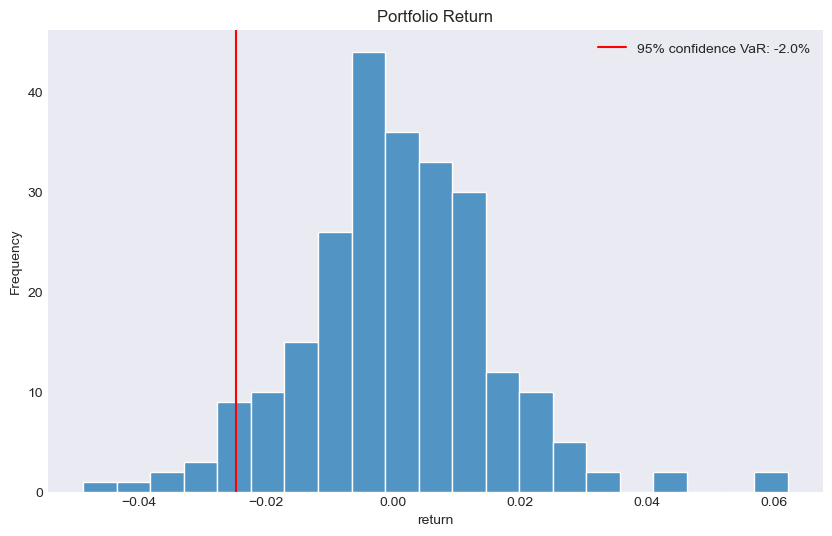

In [31]:
var_start = '2021-01-31'
var_end = '2022-01-31'
var = rp.VaR_Hist(stock_return_daily_weight['SUM'], alpha=0.05)
plt.figure(figsize=(10, 6))
sns.histplot(stock_return_daily_weight['SUM'])
plt.title('Portfolio Return')
plt.xlabel('return')
plt.ylabel('Frequency')
plt.axvline(x=-var, color='red', linestyle='-', label=f'95% confidence VaR: -{round(var, 2)*100}%')
plt.legend()
plt.show()